### Using mujoco tracking data, starting Wed 2/5/2025

In [5]:
import h5py
import matplotlib.pyplot as plt
import mujoco
import dm_control
import numpy as np
from dm_control import mjcf
from copy import deepcopy
from dm_control.mujoco.wrapper.mjbindings import enums
import imageio
import mediapy as media
import stac_mjx
import jax
from pathlib import Path

In [3]:
from jax.lib import xla_bridge
xla_bridge.get_backend().platform

/tmp/ipykernel_51288/772532765.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  xla_bridge.get_backend().platform


'cpu'

In [7]:
jax.extend.backend.get_backend()

AttributeError: module 'jax' has no attribute 'extend'

In [3]:
%load_ext autoreload
%autoreload 2
import stac_mjx

In [10]:
import os
for i in os.environ.items():
    print(i)

('USER', 'root')
('SSH_CLIENT', '10.244.2.0 23896 22')
('SHLVL', '1')
('HOME', '/root')
('SSL_CERT_FILE', '/usr/lib/ssl/cert.pem')
('LOGNAME', 'root')
('_', '/root/miniforge3/envs/stac-mjx-env/bin/python')
('VSCODE_CLI_REQUIRE_TOKEN', '72a08dd1-16ad-4087-9f0a-909f77dbefd9')
('PATH', '/root/miniforge3/envs/stac-mjx-env/bin:/root/.vscode-server/cli/servers/Stable-e249dada235c2083c83813bd65b7f4707fb97b76/server/bin/remote-cli:/root/miniforge3/envs/stac-mjx-env/bin:/root/miniforge3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin')
('VSCODE_AGENT_FOLDER', '/root/.vscode-server')
('SSL_CERT_DIR', '/usr/lib/ssl/certs')
('LANG', 'C.UTF-8')
('SHELL', '/bin/bash')
('PWD', '/root')
('SSH_CONNECTION', '10.244.2.0 23896 10.244.4.69 22')
('VSCODE_CWD', '/root')
('VSCODE_NLS_CONFIG', '{"userLocale":"en","osLocale":"en","resolvedLanguage":"en","defaultMessagesFile":"/root/.vscode-server/cli/servers/Stable-e249dada235c2083c83813bd65b7f4707fb97

In [ ]:
a# unsqueeze dim 1 of mujoco_aligned_tracking
with h5py.File("./tests/data/mujoco_aligned_tracking.h5", 'r') as f:

    # original file shape is (1000, 3, 3); unsqueezing to (1000, 1, 3, 3)
    # dset = f["tracks"][:]sdasasdas
    # del f["tracks"]
    # f.create_dataset('tracks',data=np.expand_dims(dset, 1)) # implant new-shaped dataset "X1"

    data = f["tracks"][:]
    print(data.shape)

    # shorten_file = h5py.File('./tests/data/mujoco_aligned_tracking_shorten.h5', 'w')
    # shorten_file.create_dataset('tracks', data=data[:250])
    # shorten_file.close()

(1000, 1, 3, 3)


In [12]:
with h5py.File("./tests/data/mujoco_aligned_tracking_shorten.h5") as f:
    print(f['tracks'].shape)

(250, 1, 3, 3)


In [ ]:
# Enable XLA flags if on GPU
stac_mjx.enable_xla_flags()

# Choose parent directory as base path for data files
base_path = Path("/root/vast/joshua/stac-mjx")

# Load configs
cfg = stac_mjx.load_configs(base_path / "configs")
# cfg = stac_mjx.load_configs(base_path + "/configs")

# Load data
kp_data, sorted_kp_names = stac_mjx.load_mocap(cfg, base_path)

# # # Run stac
fit_path, ik_only_path = stac_mjx.run_stac(
 cfg,
 kp_data, 
 sorted_kp_names, 
 base_path=base_path
)

Config loaded and validated.
Running ik_only()
kp_data shape: (1000, 9)
Pose Optimization:
Pose Optimization done in 27.48632001876831


In [13]:
cfg.keys()

dict_keys(['stac', 'model'])

In [17]:
cfg.model.FTOL

1e-10

In [ ]:
# ik_only_path = 'mouse_arm_ik_only.h5'
print(ik_only_path)
with h5py.File(ik_only_path) as file:
    print(file.keys())
    print(file['kp_data'])
    print(file['kp_names'][:])
    kp_data = file['kp_data'][:]
    qpos = file['qpos'][:]
    print(file['names_qpos'][:])

    print(file['offsets'][:])

    print(file['config'][()])

/root/vast/joshua/stac-mjx/mouse_arm_ik_only.h5
<KeysViewHDF5 ['config', 'kp_data', 'kp_names', 'marker_sites', 'names_qpos', 'names_xpos', 'offsets', 'qpos', 'qvel', 'xpos', 'xquat']>
<HDF5 dataset "kp_data": shape (1000, 9), type "<f4">
[b'Shoulder' b'Elbow' b'Wrist']
[b'sh_elv' b'sh_extension' b'sh_rotation' b'elbow_joint']
[[-4.2706192e-04  3.1025131e-04  3.8605838e-04]
 [-7.7045447e-04  2.7887418e-05 -1.5623801e-04]
 [ 3.8695327e-04  9.3607072e-05  1.0037370e-05]]
b'model:\n  MJCF_PATH: models/arm_model_v3_torque.xml\n  FTOL: 1.0e-08\n  ROOT_FTOL: 1.0e-08\n  LIMB_FTOL: 1.0e-10\n  N_ITERS: 2\n  KP_NAMES:\n  - Shoulder\n  - Elbow\n  - Wrist\n  KEYPOINT_MODEL_PAIRS:\n    Shoulder: scapula\n    Elbow: elbow\n    Wrist: wrist_body\n  KEYPOINT_INITIAL_OFFSETS:\n    Shoulder: 0. 0. 0.\n    Elbow: 0. 0. 0.\n    Wrist: 0. 0. 0.\n  ROOT_OPTIMIZATION_KEYPOINT: Wrist\n  TRUNK_OPTIMIZATION_KEYPOINTS:\n  - Wrist\n  KEYPOINT_COLOR_PAIRS:\n    Shoulder: 1 0 0 1\n    Elbow: 0 1 0 1\n    Wrist: 0 0

In [23]:
i = 12 # random number
print((kp_data[i] == data[i].reshape(-1,).astype(np.float32)).all())

True


In [24]:
qpos.shape

(1000, 4)

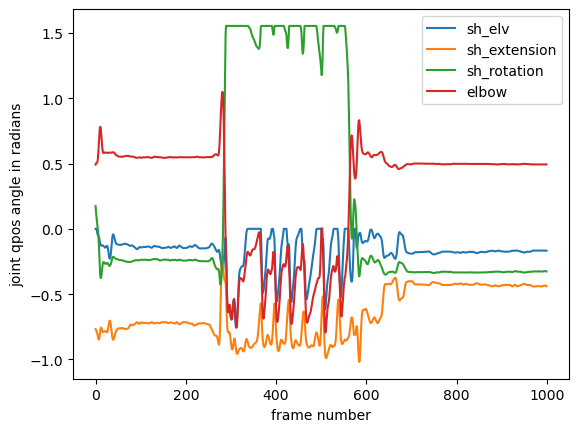

In [29]:
_len = 1000
plt.plot(np.arange(_len), qpos[:, 0], label='sh_elv')
plt.plot(np.arange(_len), qpos[:, 1], label='sh_extension')
plt.plot(np.arange(_len), qpos[:, 2], label='sh_rotation')
plt.plot(np.arange(_len), qpos[:, 3], label='elbow')
plt.xlabel('frame number')
plt.ylabel('joint qpos angle in radians')
plt.legend()

#### Get video output

In [31]:
stac = stac_mjx.viz_stac(
    data_path=ik_only_path,
    n_frames=1000,
    save_path='mujoco_arm_model.mp4',
    start_frame=0
)

[ 1.43605392e-04  3.02526394e-04 -1.99385678e-05]
[-0.00049987  0.00018014 -0.0002809 ]
[-0.00013151  0.0002097   0.00013035]


0it [00:00, ?it/s]/root/miniforge3/envs/stac-mjx-env/lib/python3.11/subprocess.py:1885: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _fork_exec(
1000it [01:52,  8.91it/s]


In [32]:
np.array(stac.kp_positions).shape

(1000, 3, 3)

In [33]:
stac_kp_data = h5py.File('./tests/data/mujoco_output_kp_data.h5', 'w')
stac_kp_data.create_dataset('tracks', data=np.array(stac.kp_positions))
stac_kp_data.close()

### Got rid of the huge balls (yay), time to dig through stac and understand why qpos is so small

In [27]:
cfg.stac.n_fit_frames
cfg.stac.infer_qvels
cfg.stac.n_frames_per_clip

1

In [ ]:
physics = mjcf.Physics.from_mjcf_model(stac._root)
mj_data = mujoco.MjData(physics.model.ptr)
mujoco.mj_kinematics(physics.model.ptr, mj_data)

""

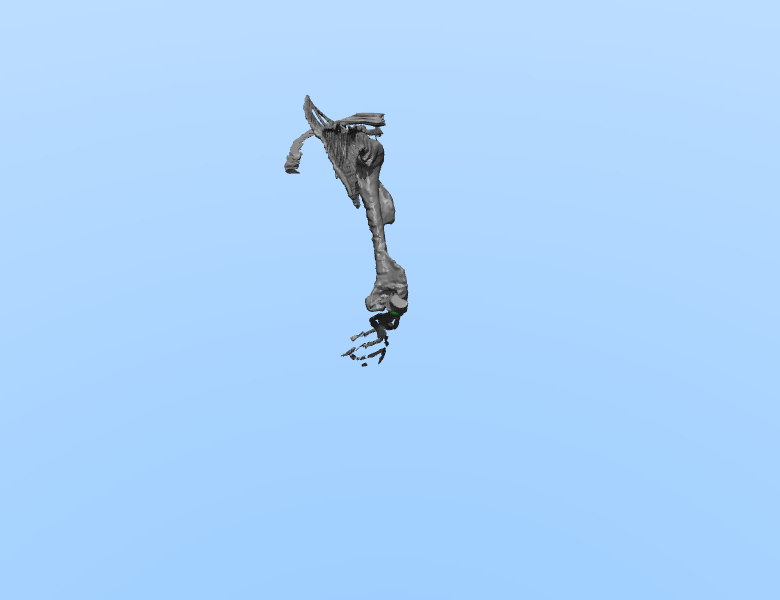

In [25]:
# model = mujoco.MjModel.from_xml_string(xml)
# data = mujoco.MjData(model)

# with mujoco.Renderer(physics.model.ptr) as renderer:
renderer = mujoco.Renderer(physics.model.ptr, height=600, width=780)

# mj_data.qpos = [.2, .2, .2, .2]
mujoco.mj_fwdPosition(physics.model.ptr, mj_data)
renderer.update_scene(mj_data)


media.show_image(renderer.render())
renderer.close()

In [14]:
# a = [key for key in cfg.model.KEYPOINT_MODEL_PAIRS.keys()]
# print(a)
# [axis.convert_key_item(key) for key in a]
# dir(axis)
# axis.convert_key_item(10)
# type(axis)
site_names = [physics.model.id2name(i, 'site') for i in range(physics.model.nsite)]
physics.data.body
# cfg.model.KEYPOINT_MODEL_PAIRS.keys()
site_names = [physics.model.id2name(i, 'body') for i in range(physics.model.nbody)]
print(site_names)

['world', 'ground', 'clavicle', 'scapula', 'humerus', 'ulna', 'elbow', 'radius', 'hand']


In [71]:
mj_data = mujoco.MjData(physics.model.ptr)
mj_data.xpos

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [ ]:
# physics.model.ptr.nbody
for i in range(10):
    print(physics.model.id2name(i, 'body'))

world
ground
clavicle
scapula
humerus
ulna
elbow
radius
hand



## Visualizing Input and Output

In [45]:
with h5py.File("./mouse_arm_ik_only.h5", 'r') as file:
    print(file.keys())
    # print(f"{file['kp_data']}")
    data = file['qpos'][:]
    datax = file['xpos'][:]
    names = file['names_xpos'][:]

<KeysViewHDF5 ['config', 'kp_data', 'kp_names', 'marker_sites', 'names_qpos', 'names_xpos', 'offsets', 'qpos', 'qvel', 'xpos', 'xquat']>
